# CLIP + SAM

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import ImageFolder
import albumentations as A
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image, ImageDraw
import clip

In [ ]:
sam_checkpoint = "<path to trained SAM weights: sam_vit_h_4b8939.pth>"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

In [4]:
# Download the model weights to load them here
mask_generator = SamAutomaticMaskGenerator(build_sam(checkpoint=sam_checkpoint))

In [23]:
image_path = "<path to demo image inside assests/pokemon.jpeg>"

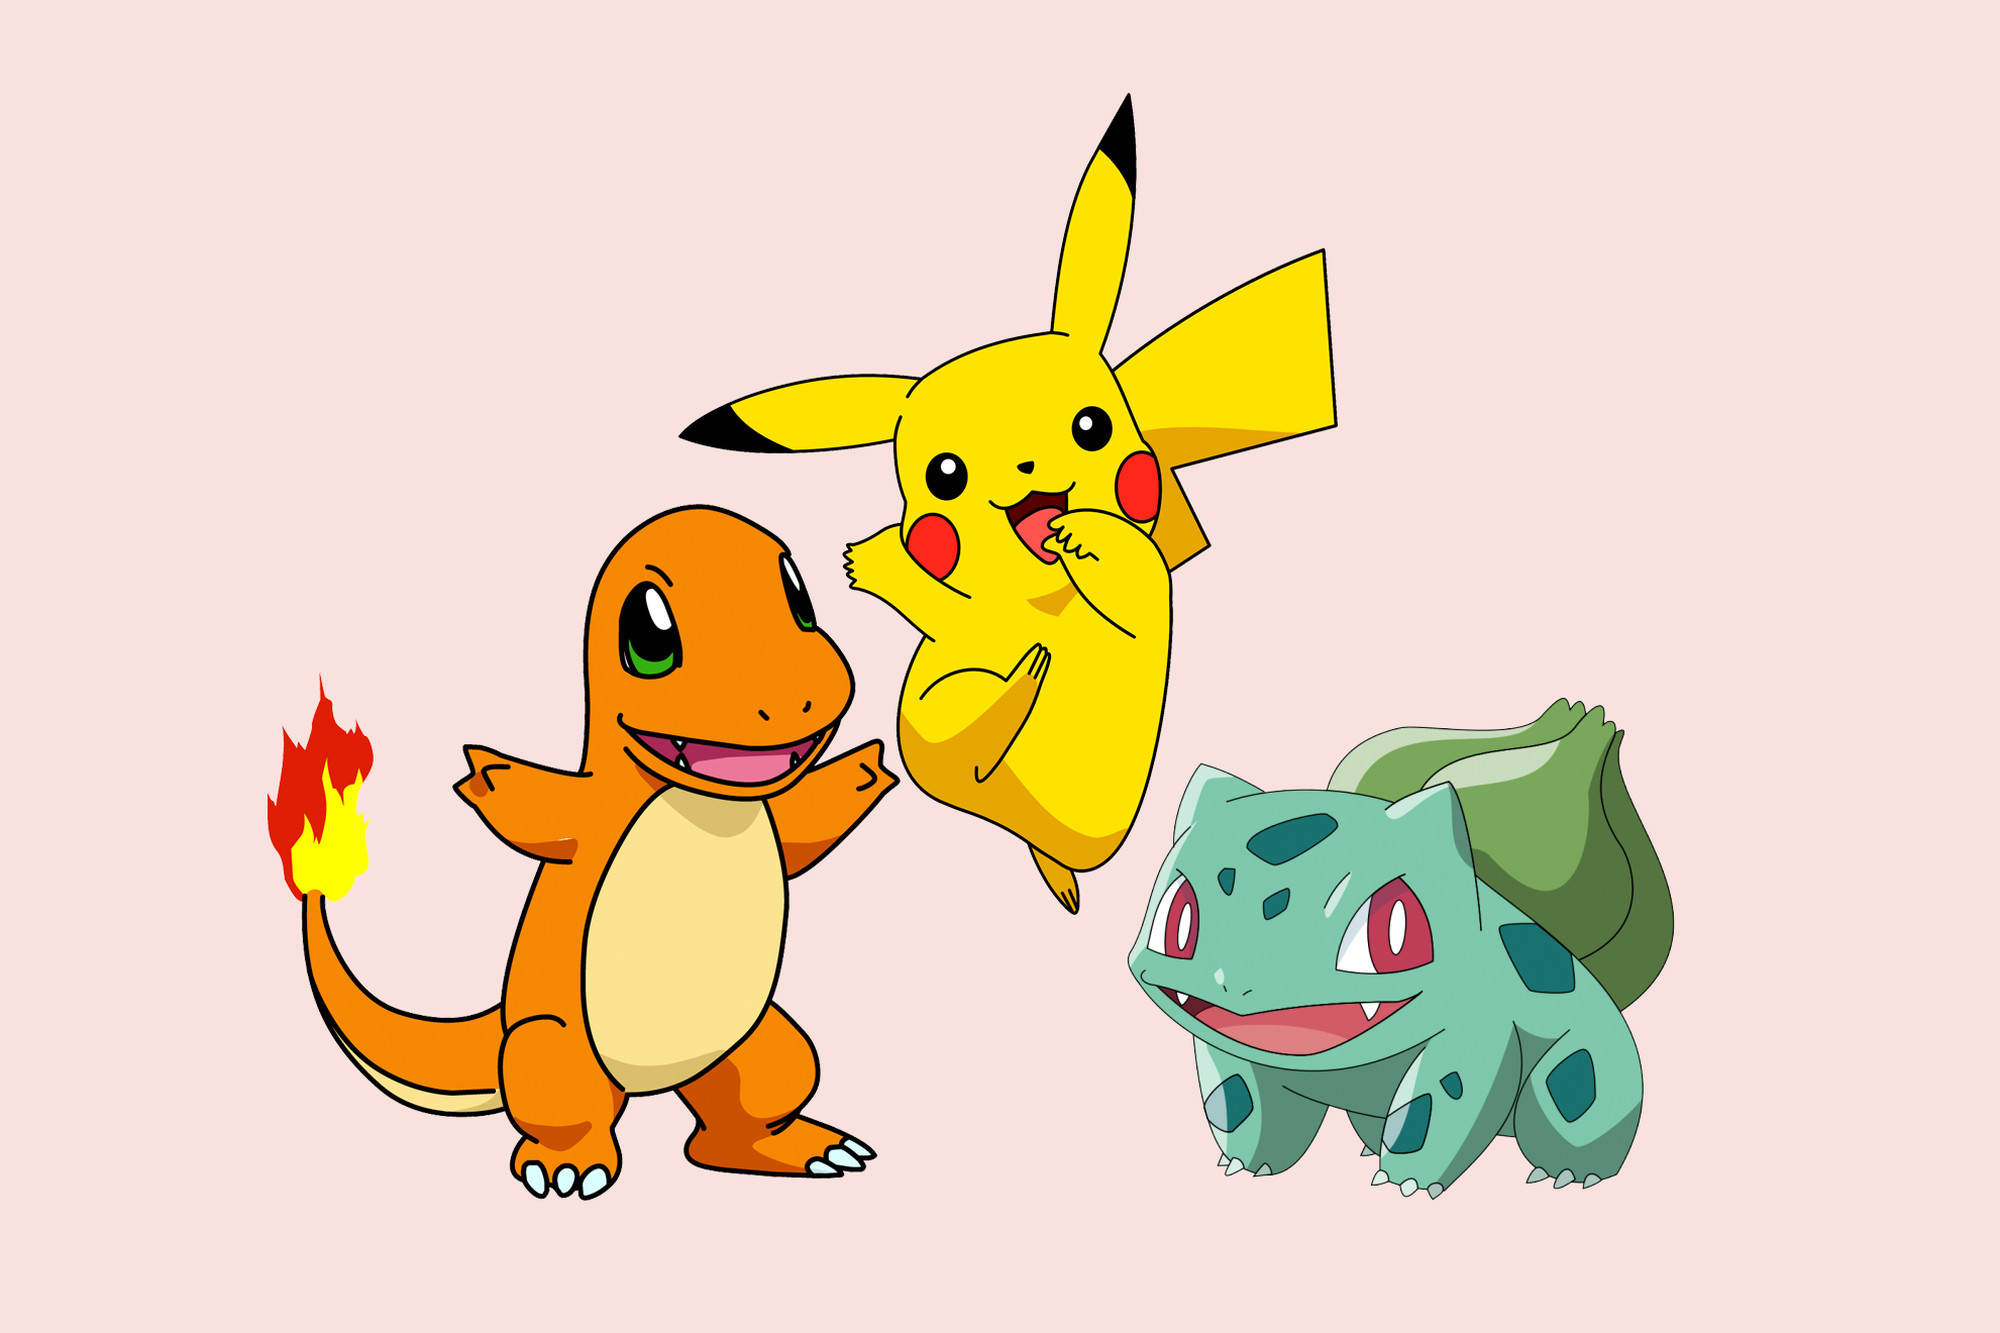

In [28]:
im = Image.open(image_path)
im

In [6]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)

In [7]:
def convert_box_xywh_to_xyxy(box):
    """
    Convert bounding box from [x, y, w, h] format to [x1, y1, x2, y2] format.

    Args:
        box (list): Bounding box coordinates in [x, y, w, h] format.

    Returns:
        list: Bounding box coordinates in [x1, y1, x2, y2] format.
    """
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [8]:
def segment_image(image, segmentation_mask):
    """
    Segment an image using a binary segmentation mask.

    Args:
        image (PIL.Image.Image): Input image.
        segmentation_mask (ndarray): Binary segmentation mask.

    Returns:
        PIL.Image.Image: Segmented image with the background set to black.
    """
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [9]:
# Cut out all masks
image = Image.open(image_path)
cropped_boxes = []

for mask in masks:
    cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

In [10]:
def filter_annotations(annotations):
    """
    Filter a list of annotations based on area and segmentation overlap.

    Args:
        annotations (list): List of annotation dictionaries.

    Returns:
        list: Filtered list of annotations.
    """
    annotations.sort(key=lambda x: x['area'], reverse=True)
    to_remove = set()
    for i in range(0, len(annotations)):
        a = annotations[i]
        for j in range(i + 1, len(annotations)):
            b = annotations[j]
            if i != j and j not in to_remove:
                # check if 
                if b['area'] < a['area']:
                    if (a['segmentation'] & b['segmentation']).sum() / b['segmentation'].sum() > 0.8:
                        to_remove.add(j)
    return [a for i, a in enumerate(annotations) if i not in to_remove]

In [11]:
annotations = masks
new_annotaions = filter_annotations(annotations)
new_annotaions.pop(0)
cropped_boxes = []
for mask in new_annotaions:
    cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

In [12]:
# Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

In [13]:
@torch.no_grad()
def retriev(elements: list[Image.Image], search_text: str) -> int:
    """
    Retrieves the probability of a given search text matching each image in the list.

    Args:
        elements (list[Image.Image]): A list of images to be searched.
        search_text (str): The text to be used for searching.

    Returns:
        int: The probability of the search text matching each image in the list.
    """
    preprocessed_images = [preprocess(image).to(device) for image in elements]
    tokenized_text = clip.tokenize([search_text]).to(device)
    stacked_images = torch.stack(preprocessed_images)
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    probs = 100. * image_features @ text_features.T
    return probs[:, 0].softmax(dim=0)

In [14]:
def get_indices_of_values_above_threshold(values, threshold):
    """
    Retrieves the indices of values in a list that are above a given threshold.

    Args:
        values (list): A list of values to be checked.
        threshold: The threshold value for comparison.

    Returns:
        list: A list of indices corresponding to values that are above the threshold.
    """
    return [i for i, v in enumerate(values) if v > threshold]

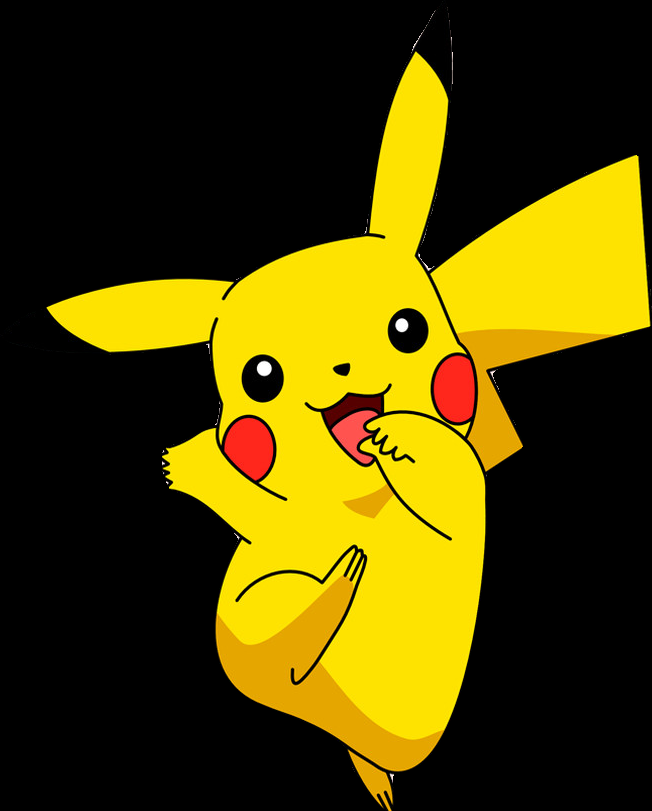

In [17]:
scores = retriev(cropped_boxes, "Pikachu")
max_idx = torch.argmax(scores)
cropped_boxes[max_idx]

In [30]:
image_path = "<path to test image inside assests/poke.jpg>"

In [19]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)

In [20]:
# Cut out all masks
image = Image.open(image_path)
cropped_boxes = []

for mask in masks:
    cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

In [21]:
annotations = masks
new_annotaions = filter_annotations(annotations)
new_annotaions.pop(0)
cropped_boxes = []
for mask in new_annotaions:
    cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

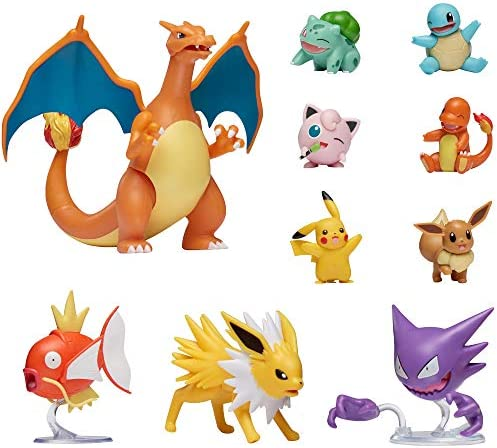

In [31]:
im = Image.open(image_path)
im

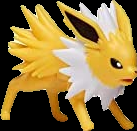

In [43]:
scores = retriev(cropped_boxes, "pikachu")
max_idx = torch.argmax(scores)
cropped_boxes[max_idx]